# Regularized inverse integral transform with a Gaussian kernel

### Imports:

In [1]:
import numpy as np
import scipy.sparse.linalg as splin
import matplotlib.pyplot as plt

### Global parameters:

In [2]:
xmin, xmax = 0, 5
n_points = 200
intensity = 1e4
kernel_width = 0.2

x = np.linspace(xmin, xmax, n_points)

### Functions for generating the input signal:

In [3]:
def laue(x_i):
    return intensity*np.sinc(x_i)**2

In [4]:
def add_poisson(x_i):
    return np.random.poisson(np.maximum(x_i, 10.))

### Gaussian kernel and convolution:

In [5]:
def kernel_gauss(x_i, y_i, sigma=kernel_width):
    diff_squared = (x_i-y_i)**2
    return np.exp(-diff_squared/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

In [6]:
def kernel_array(x_i, kernel, normalize=True):
    result = np.fromfunction(lambda i, j: kernel(x_i[i], x_i[j]), (len(x_i), len(x_i)), dtype=int)
    # normalize: set sum of elements in each row to 1
    if normalize:
        normalization_vector = np.sum(result, 1)
        result = result / normalization_vector[:,None]
    else:
        result = result * (xmax - xmin) / n_points
    return result

### Create input signal:

In [7]:
input_signal = laue(x)

### Create Gaussian kernel:

In [8]:
kernel = kernel_array(x, kernel_gauss, False)

### Apply kernel and noise to ideal input signal:

In [9]:
conv_signal = np.dot(kernel, input_signal)
noisy = add_poisson(conv_signal)

### Plot Gaussian kernel:

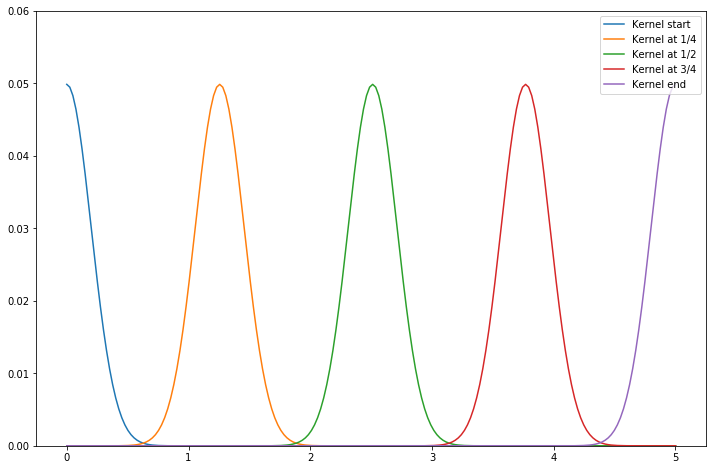

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(x, kernel[0], label='Kernel start')
plt.plot(x, kernel[len(x)//4], label='Kernel at 1/4')
plt.plot(x, kernel[len(x)//2], label='Kernel at 1/2')
plt.plot(x, kernel[3*len(x)//4], label='Kernel at 3/4')
plt.plot(x, kernel[len(x)-1], label='Kernel end')
plt.legend()
plt.ylim((0, 0.06))
plt.show()

### Plot ideal input signal, its convolution with the Gaussian kernel and a noisy version thereof:

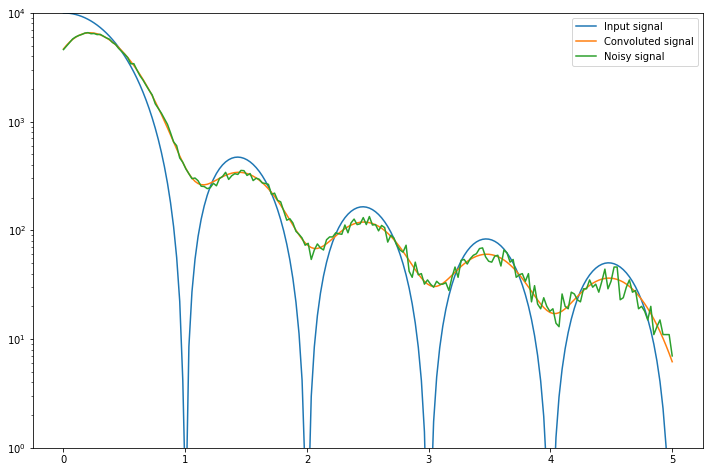

In [11]:
plt.figure(figsize=(12, 8))
plt.semilogy(x, input_signal, label='Input signal')
plt.semilogy(x, conv_signal, label='Convoluted signal')
plt.semilogy(x, noisy, label='Noisy signal')
plt.legend()
plt.ylim((1, intensity))
plt.show()

### Calculate and plot direct inverse applied to noisy signal:

In [12]:
kernel_inv = np.linalg.inv(kernel)
direct_inverse = np.dot(kernel_inv, noisy)
direct_inverse_clean = np.dot(kernel_inv, conv_signal)

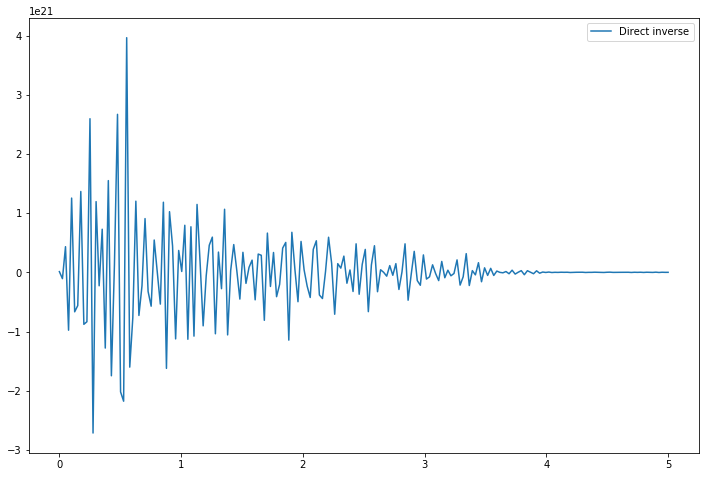

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(x, direct_inverse, label='Direct inverse')
plt.legend()
plt.show()

### Calculate and plot classical least squares solution:

In [14]:
lstsq_sol = np.linalg.lstsq(kernel, noisy, rcond=1e-8)
lstsq_sol_clean = np.linalg.lstsq(kernel, conv_signal, rcond=1e-8)

In [15]:
np.linalg.norm(lstsq_sol[0]), np.linalg.norm(lstsq_sol[1])

(854634829.9935004, 0.0)

In [16]:
np.linalg.norm(lstsq_sol_clean[0]), np.linalg.norm(lstsq_sol_clean[1])

(37102.91646382372, 0.0)

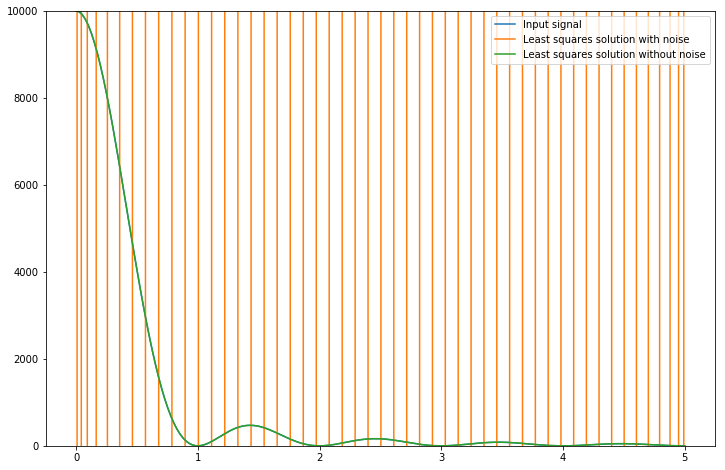

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(x, input_signal, label='Input signal')
plt.plot(x, lstsq_sol[0], label='Least squares solution with noise')
plt.plot(x, lstsq_sol_clean[0], label='Least squares solution without noise')
plt.legend()
plt.ylim(1, intensity)
plt.show()

### Calculate and plot Tikhonov-regularized least squares solution:

In [18]:
tr_lstsq_sol = splin.lsmr(kernel, noisy, damp=0.15)
tr_lstsq_sol_clean = splin.lsmr(kernel, conv_signal, damp=0.15)

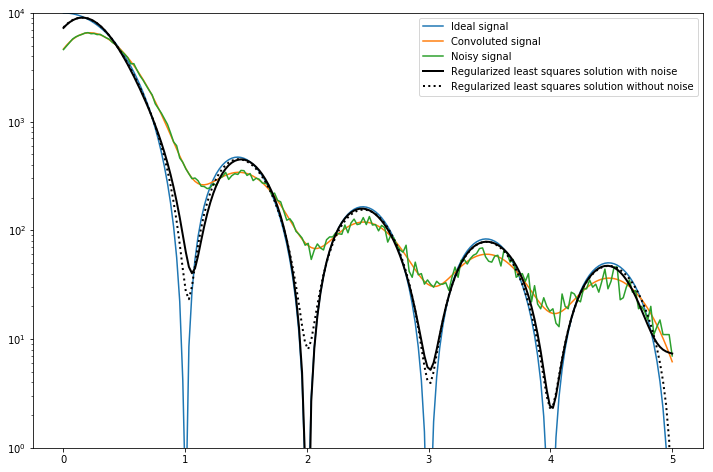

In [19]:
plt.figure(figsize=(12, 8))
plt.semilogy(x, input_signal, label='Ideal signal')
plt.semilogy(x, conv_signal, label='Convoluted signal')
plt.semilogy(x, noisy, label='Noisy signal')
plt.semilogy(x, tr_lstsq_sol[0], color='k', linewidth=2, label='Regularized least squares solution with noise')
plt.semilogy(x, tr_lstsq_sol_clean[0], 'k:', linewidth=2, label='Regularized least squares solution without noise')
plt.legend()
plt.ylim((1, intensity))
plt.show()

### Calculate forward errors for given regularization parameter:

In [20]:
def tr_lstsq_error_total(damp):
    sol = splin.lsmr(kernel, noisy, damp)[0]
    diff = sol - input_signal
    return np.sum(np.square(diff))
def tr_lstsq_error_reg(damp):
    sol = splin.lsmr(kernel, conv_signal, damp)[0]
    diff = sol - input_signal
    return np.sum(np.square(diff))
def tr_lstsq_error_pert(damp):
    sol_noisy = splin.lsmr(kernel, noisy, damp)[0]
    sol_exact = splin.lsmr(kernel, conv_signal, damp)[0]
    diff = sol_noisy - sol_exact
    return np.sum(np.square(diff))

In [21]:
x_damp = np.linspace(0, 0.3, 200)
tr_errors_total = np.asarray([ tr_lstsq_error_total(x) for x in x_damp])
tr_errors_reg = np.asarray([ tr_lstsq_error_reg(x) for x in x_damp])
tr_errors_pert = np.asarray([ tr_lstsq_error_pert(x) for x in x_damp])

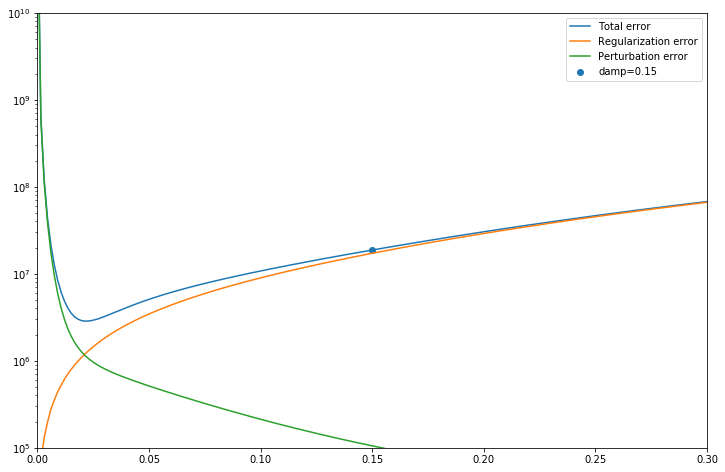

In [22]:
plt.figure(figsize=(12, 8))
plt.semilogy(x_damp, tr_errors_total, label='Total error')
plt.semilogy(x_damp, tr_errors_reg, label='Regularization error')
plt.semilogy(x_damp, tr_errors_pert, label='Perturbation error')
plt.scatter(0.15, tr_lstsq_error_total(0.15), label='damp=0.15')
plt.legend()
plt.xlim(0, 0.3)
plt.ylim(1e5, 1e10)
plt.show()

### L-curve for Tikhonov regularization

In [23]:
def tr_lstsq_residual_norm(damp):
    sol = splin.lsmr(kernel, noisy, damp)
    return sol[3]
def tr_lstsq_sol_norm(damp):
    sol = splin.lsmr(kernel, noisy, damp)
    return sol[7]

#### Let damping parameter vary between 1e-6 and 10:

In [24]:
log_x_damp2 = np.linspace(-6, 1, 200)
x_damp2 = 10**log_x_damp2
tr_residual_norms = np.asarray([ tr_lstsq_residual_norm(x) for x in x_damp2])
tr_sol_norms = np.asarray([ tr_lstsq_sol_norm(x) for x in x_damp2])

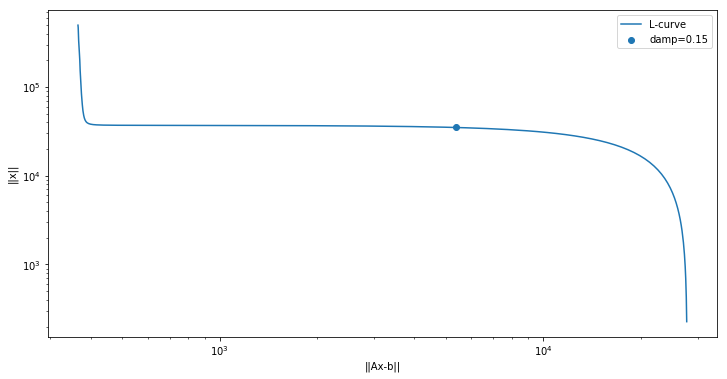

In [25]:
plt.figure(figsize=(12, 6))
plt.loglog(tr_residual_norms, tr_sol_norms, label='L-curve')
plt.scatter(tr_lstsq_residual_norm(0.15), tr_lstsq_sol_norm(0.15), label='damp=0.15')
plt.xlabel('||Ax-b||')
plt.ylabel('||x||')
plt.legend()
plt.show()

### Anscombe transform of signals:

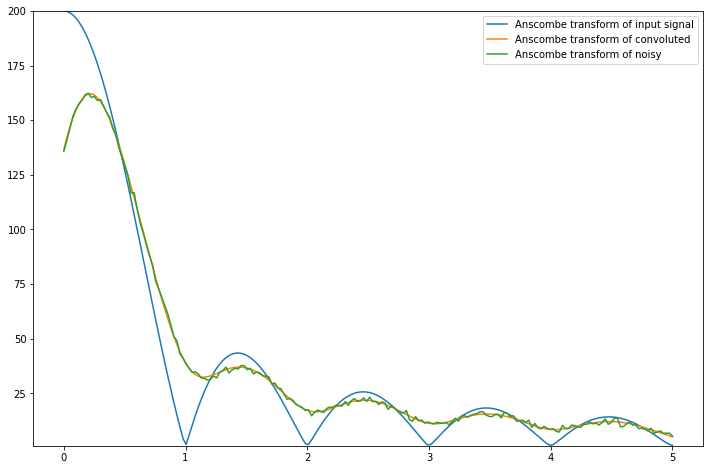

In [26]:
input_anscombe = 2*np.sqrt(input_signal+3/8)
conv_signal_anscombe = 2*np.sqrt(conv_signal+3/8)
noisy_anscombe = 2*np.sqrt(noisy+3/8)
plt.figure(figsize=(12, 8))
plt.plot(x, input_anscombe, label='Anscombe transform of input signal')
plt.plot(x, conv_signal_anscombe, label='Anscombe transform of convoluted')
plt.plot(x, noisy_anscombe, label='Anscombe transform of noisy')
plt.legend()
plt.ylim((1, 2*np.sqrt(intensity+3/8)))
plt.show()

## Weighted least squares

### Scale output and kernel by square root of output:

In [27]:
scaling_vector = np.minimum(1e2/(np.pi*np.maximum(x, 1e-6)), 1e2)
scaled_noisy = noisy/scaling_vector
scaled_kernel = np.fromfunction(lambda i, j: kernel[i, j]/scaling_vector[i], (len(scaling_vector), len(scaling_vector)),
                                dtype=int)

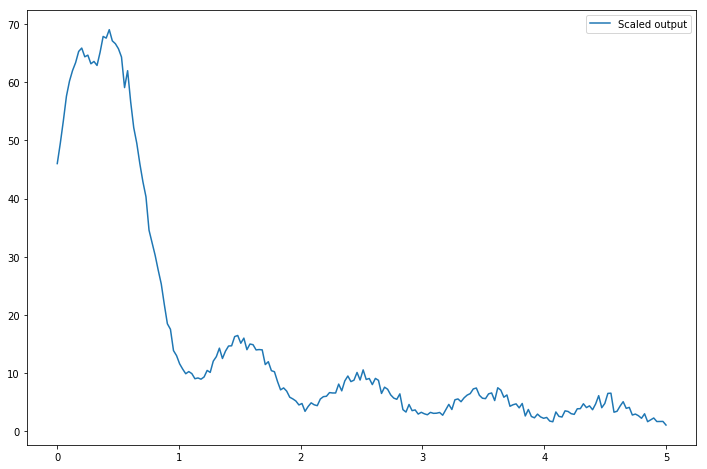

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(x, scaled_noisy, label='Scaled output')
plt.legend()
plt.show()

### Plot scaled Gaussian kernel:

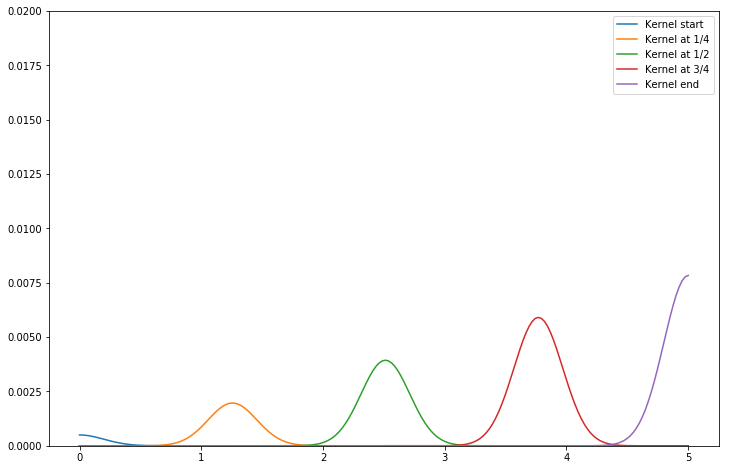

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(x, scaled_kernel[0], label='Kernel start')
plt.plot(x, scaled_kernel[len(x)//4], label='Kernel at 1/4')
plt.plot(x, scaled_kernel[len(x)//2], label='Kernel at 1/2')
plt.plot(x, scaled_kernel[3*len(x)//4], label='Kernel at 3/4')
plt.plot(x, scaled_kernel[len(x)-1], label='Kernel end')
plt.legend()
plt.ylim((0, 0.02))
plt.show()

### Calculate (regularized) least squares solution form scaled kernel and output:

In [30]:
lstsq_sol_sc = np.linalg.lstsq(scaled_kernel, scaled_noisy, rcond=1e-8)
tr_lstsq_sol_sc = splin.lsmr(scaled_kernel, scaled_noisy, damp=0.01)

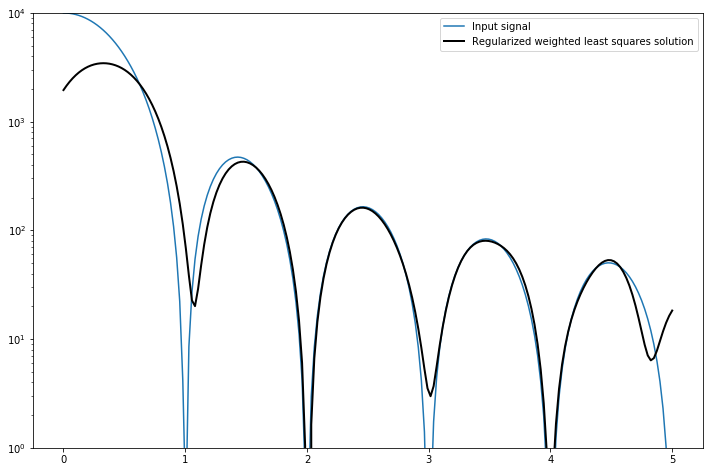

In [31]:
plt.figure(figsize=(12, 8))
plt.semilogy(x, input_signal, label='Input signal')
plt.semilogy(x, tr_lstsq_sol_sc[0], 'k', linewidth=2, label='Regularized weighted least squares solution')
plt.legend()
plt.ylim((1, intensity))
plt.show()

In [32]:
scaling_vector2 = np.minimum(1e2/(np.pi*np.maximum(x, 1e-6)), 1e2)
scaled_noisy2 = noisy/scaling_vector2
scaled_kernel2 = np.fromfunction(lambda i, j: kernel[i, j]*scaling_vector2[j]/scaling_vector2[i],
                                 (len(scaling_vector2), len(scaling_vector2)), dtype=int)

In [33]:
lstsq_sol_sc2 = np.linalg.lstsq(scaled_kernel2, scaled_noisy2, rcond=1e-8)
tr_lstsq_sol_sc2 = splin.lsmr(scaled_kernel2, scaled_noisy2, damp=0.15)

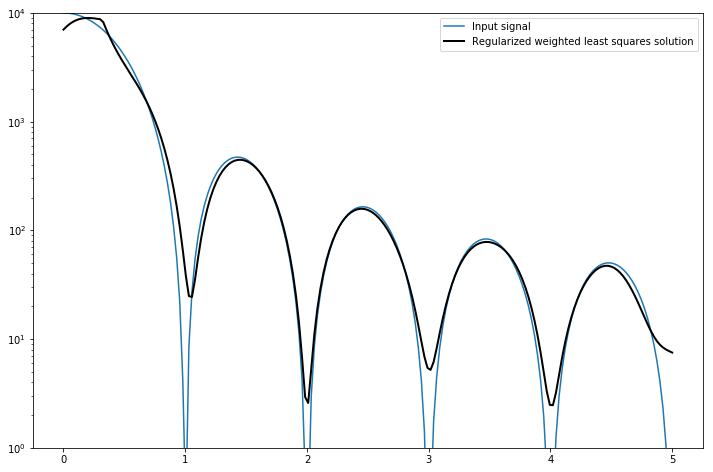

In [34]:
plt.figure(figsize=(12, 8))
plt.semilogy(x, input_signal, label='Input signal')
plt.semilogy(x, tr_lstsq_sol_sc2[0]*scaling_vector2, 'k', linewidth=2, label='Regularized weighted least squares solution')
plt.legend()
plt.ylim((1, intensity))
plt.show()